<h1><center>Machine Learning in Public Policy</center></h1>
<center>Title: Homework 1</center>
<center>Author: Rose Gao</center>

<h3><center>Problem 1: Data Acquisition and Analysis</center></h3>
This problem deals with data from the 311 calls in Chicago. Your task is to download data about 311 requests from the Chicago Open Data Portal and analyze it to better understand what type of requests come from what (type of) neighborhoods.
You should use Python to do the following tasks.

1. You should download and combine data from the open data portal for 2017 about the following 311 requests
    - Graffiti Removal
    - Vacant and Abandoned Buildings Reported
    - Alley Lights Out
2. Generate summary statistics for these requests including but not limited to number of requests of each type (and subtype within each of the types above) over time, by neighborhood, response time by the city. Please use a combination of tables and graphs to present these summary stats.
3. Based on these summary statistics, tell me 5 interesting things you learned (about Chicago and the different neighborhoods) using the 311 data.

### Data Acquisition

In [71]:
from sodapy import Socrata
import pandas_profiling

import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [73]:
def get_2017_chicago_data(dataset_identifier, date_col):
    '''
    Given dataset name, query all 2017 entries for that dataset.
    Inputs: dataset (string), name of dataset
    Returns: results_df (DataFrame), 2017 data
    '''
    socrata_domain = "data.cityofchicago.org"
    client = Socrata(socrata_domain, None)    

    # Get all results from 2017 from each dataset using SODA    
    results = client.get(dataset_identifier, 
                         where="{} between '2017-01-01T00:00:00' and '2017-12-31T23:59:59'".format(date_col),
                         limit=1000000)
        
    results_df = pd.DataFrame.from_records(results)
    return results_df

In [74]:
# Datasets dictionary with the format of dataset: (dataset identifier, date column name)
d = {'graffiti_removal': ('cdmx-wzbz', 'creation_date'),
     'vacant_buildings': ('yama-9had', 'date_service_request_was_received'),
     'alley_lights_out': ('j9pw-ad5p', 'creation_date')}

In [75]:
graffiti_removal = get_2017_chicago_data(d['graffiti_removal'][0], d['graffiti_removal'][1])
vacant_buildings = get_2017_chicago_data(d['vacant_buildings'][0], d['vacant_buildings'][1])
alley_lights_out = get_2017_chicago_data(d['alley_lights_out'][0], d['alley_lights_out'][1])

#### Data Preprocessing

In [76]:
# Format vacant buildings to match the other two datasets:
# 1. rename service request date and type columns to match with graffiti removal
vacant_buildings.rename(columns = {'date_service_request_was_received':'creation_date',
                                   'service_request_type':'type_of_service_request'}, inplace=True)

# 2. create new address column to match graffiti removal
vacant_buildings['street_address'] = vacant_buildings['address_street_number'] + ' ' +\
                                     vacant_buildings['address_street_direction'] + ' ' +\
                                     vacant_buildings['address_street_name'] + ' ' +\
                                     vacant_buildings['address_street_suffix']
# 3. drop other address columns
vacant_buildings = vacant_buildings.drop(['address_street_number', 'address_street_direction',
                                          'address_street_name', 'address_street_suffix'], axis = 1)

In [79]:
# concatenate dataframes
df = pd.concat([graffiti_removal, vacant_buildings, alley_lights_out], axis=0).reset_index(drop=True)

In [80]:
# convert columns to appropriate types
df['community_area'] = df['community_area'].astype(float)
df['completion_date'] = pd.to_datetime(df['completion_date'], format="%Y-%m-%dT0%H:%M:%S.%f")
df['creation_date'] = pd.to_datetime(df['creation_date'], format="%Y-%m-%dT0%H:%M:%S.%f")
df['latitude'] = df['latitude'].astype(float)
df['longitude'] = df['longitude'].astype(float)
df['police_district'] = df['police_district'].astype(float)
df['ward'] = df['ward'].astype(float)
df['x_coordinate'] = df['x_coordinate'].astype(float)
df['y_coordinate'] = df['y_coordinate'].astype(float)
df['zip_code'] = df['zip_code'].astype(float)

# drop location column (does not give more information)
df = df.drop('location', axis = 1)

# drop duplicates
df = df[(df['status'] != 'Completed - Dup') | (df['status'] != 'Open - Dup')]

In [81]:
# save to pickle
df.to_pickle('data/service_requests_2017.pkl')

## Analysis

Generate summary statistics for these requests including but not limited to number of requests of each type (and subtype within each of the types above) over time, by neighborhood, response time by the city. Please use a combination of tables and graphs to present these summary stats.

Based on these summary statistics, tell me 5 interesting things you learned (about Chicago and the different neighborhoods) using the 311 data.

In [92]:
df = pd.read_pickle('data/service_requests_2017.pkl')

In [93]:
df['type_of_service_request'].value_counts()

Graffiti Removal             112779
Alley Light Out               27896
Vacant/Abandoned Building      3666
Name: type_of_service_request, dtype: int64

In [95]:
df.describe()

,community_area,latitude,longitude,police_district,ward,x_coordinate,y_coordinate,zip_code
count,144318.000000,144249.000000,144249.000000,144318.000000,144318.000000,1.443110e+05,1.443110e+05,144241.000000
mean,33.673693,41.871491,-87.688564,13.074384,24.964225,1.159894e+06,1.896428e+06,60617.979922
std,21.893988,0.078665,0.046569,5.971877,13.852663,1.276369e+04,2.859731e+04,798.270550
min,0.000000,41.645931,-87.882548,0.000000,0.000000,1.096673e+06,1.814385e+06,0.000000
25%,17.000000,41.808308,-87.716113,9.000000,13.000000,1.152401e+06,1.873431e+06,60617.000000
50%,28.000000,41.886680,-87.688893,12.000000,25.000000,1.159679e+06,1.901980e+06,60628.000000
75%,58.000000,41.935870,-87.663337,17.000000,35.000000,1.166771e+06,1.919801e+06,60640.000000
max,77.000000,42.022535,-87.524531,31.000000,50.000000,1.205116e+06,1.951491e+06,60827.000000


#### Check Missing Values

In [101]:
df[df['type_of_service_request'] == 'Graffiti Removal'].isnull().sum()

any_people_using_property_homeless_childen_gangs_                     112779
community_area                                                            10
completion_date                                                            6
creation_date                                                              0
if_the_building_is_open_where_is_the_entry_point_                     112779
is_building_open_or_boarded_                                          112779
is_the_building_currently_vacant_or_occupied_                         112779
is_the_building_vacant_due_to_fire_                                   112779
latitude                                                                  80
location_of_building_on_the_lot_if_garage_change_type_code_to_bgd_    112779
longitude                                                                 80
police_district                                                           10
service_request_number                                                     0

In [103]:
df[df['type_of_service_request'] == 'Alley Light Out'].isnull().sum()

any_people_using_property_homeless_childen_gangs_                     27896
community_area                                                            9
completion_date                                                        3717
creation_date                                                             0
if_the_building_is_open_where_is_the_entry_point_                     27896
is_building_open_or_boarded_                                          27896
is_the_building_currently_vacant_or_occupied_                         27896
is_the_building_vacant_due_to_fire_                                   27896
latitude                                                                 11
location_of_building_on_the_lot_if_garage_change_type_code_to_bgd_    27896
longitude                                                                11
police_district                                                           9
service_request_number                                                    0
ssa         

In [104]:
df[df['type_of_service_request'] == 'Vacant/Abandoned Building'].isnull().sum()

any_people_using_property_homeless_childen_gangs_                      518
community_area                                                           4
completion_date                                                       3666
creation_date                                                            0
if_the_building_is_open_where_is_the_entry_point_                     1867
is_building_open_or_boarded_                                           509
is_the_building_currently_vacant_or_occupied_                          508
is_the_building_vacant_due_to_fire_                                    512
latitude                                                                 1
location_of_building_on_the_lot_if_garage_change_type_code_to_bgd_     514
longitude                                                                1
police_district                                                          4
service_request_number                                                   0
ssa                      

For questions about neighborhood, zip codes are missing more often for each of the service request datasets than community areas, wards, and police districts. Thus, I'll decide to use community areas as neighborhoods.

#### Correlation Heatmap

I want to see if there are any correlations between community areas and type of request, but I need to first create dummy variables for type of request categories.

In [16]:
df = pd.concat([df, pd.get_dummies(df['type_of_service_request'])], axis=1)

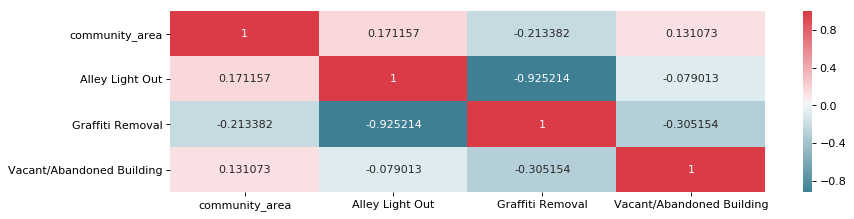

In [30]:
corr = df[['community_area', 'Alley Light Out', 'Graffiti Removal', 'Vacant/Abandoned Building']].corr()
fig = plt.figure(figsize=(12, 3), dpi=80) 
sns.heatmap(corr, annot=True, fmt='g', cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

#### Insight 1: 
While community area should not be correlated with service requests, it is weakly correlated with all 3 types of requests.

#### Over Time

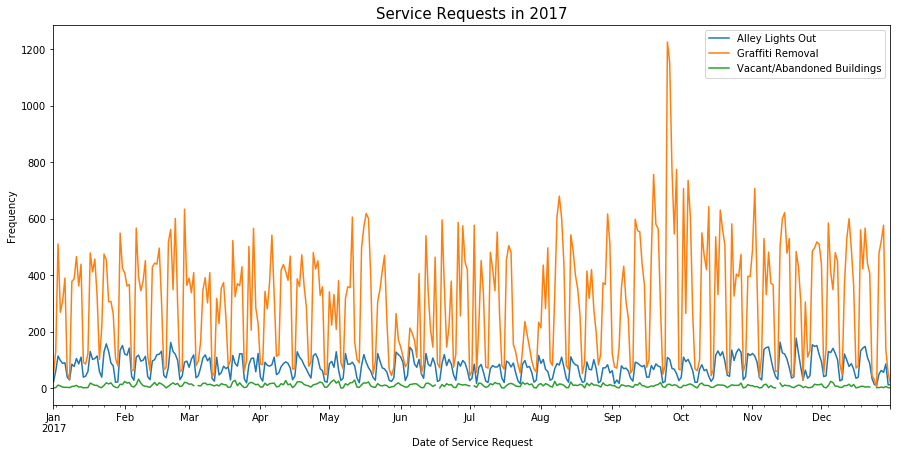

In [8]:
# visualize service requests over time
df.groupby(['creation_date', 'type_of_service_request']).size().unstack().plot(figsize = (15,7))

plt.title('Service Requests in 2017', fontsize=15)
plt.xlabel('Date of Service Request')
plt.ylabel('Frequency')
plt.legend(('Alley Lights Out', 'Graffiti Removal', 'Vacant/Abandoned Buildings'))

#### Insight #2: Service requests are cyclical
Let's check if it's a weekly cycle

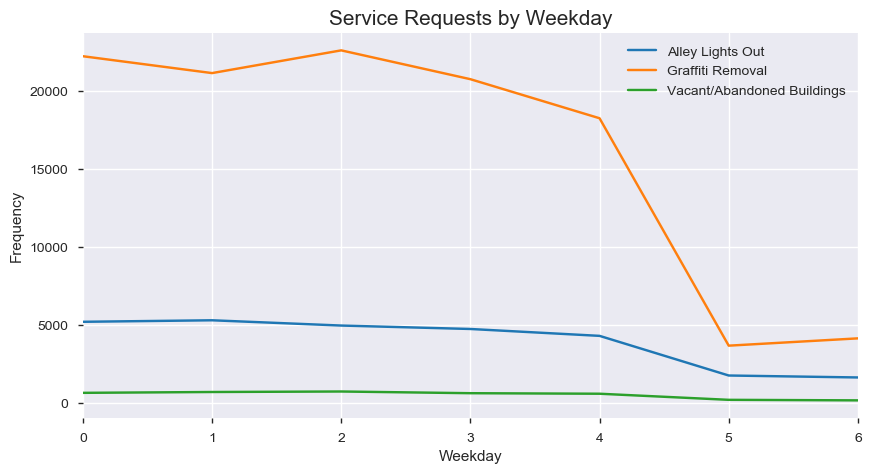

In [152]:
# create weekday column
df['weekday'] = df['creation_date'].dt.dayofweek

# visualize service requests by weekday
df.groupby(['weekday', 'type_of_service_request']).size().unstack().plot(figsize=(10,5))

plt.title('Service Requests by Weekday', fontsize=15)
plt.xlabel('Weekday')
plt.ylabel('Frequency')
plt.legend(('Alley Lights Out', 'Graffiti Removal', 'Vacant/Abandoned Buildings'))

It seems that service request creation dates are most often on Mondays - Fridays, with a slightly lower number on Fridays. It could be that requests are entered into the dataset by city employees.

#### By Neighborhood

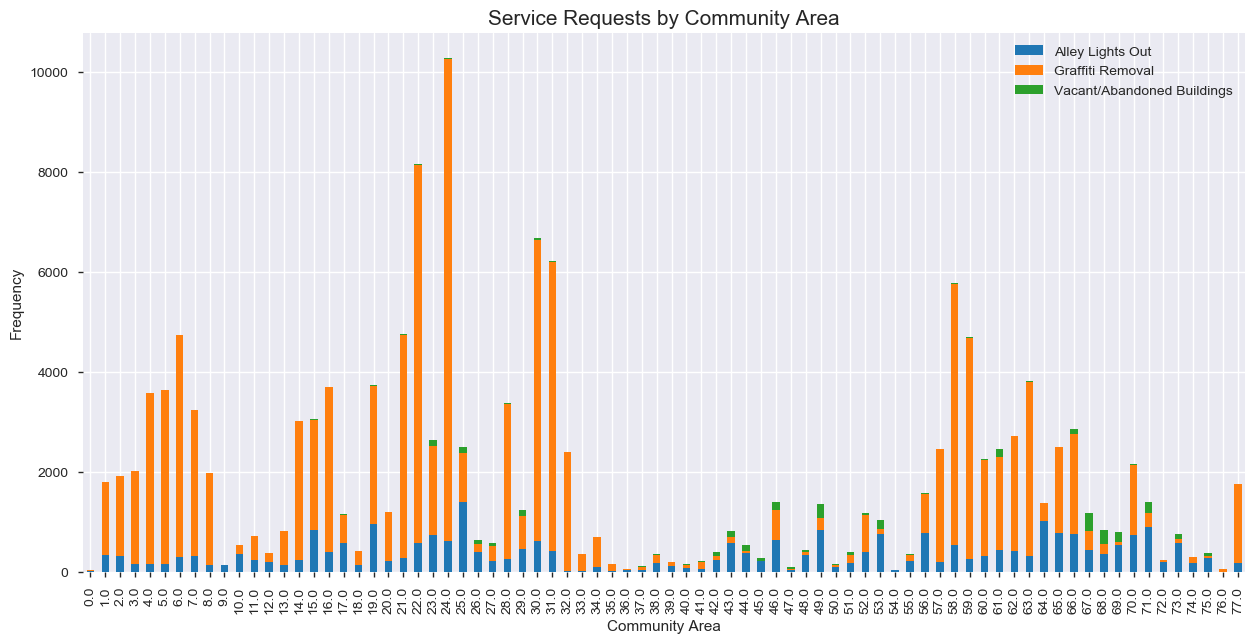

In [151]:
# visualize service requests by wards
df.groupby(['community_area', 'type_of_service_request']).size().unstack().plot(kind='bar', stacked=True, figsize=(15,7))

plt.title('Service Requests by Community Area', fontsize=15)
plt.xlabel('Community Area')
plt.ylabel('Frequency')
plt.legend(('Alley Lights Out', 'Graffiti Removal', 'Vacant/Abandoned Buildings'))

While some community areas have a lot of service requests, others have very few, such as community areas 33-55. It will be interesting to see the socioeconomic breakdown of community areas later, when I integrate ACS data.

#### By Response Time

C:\Users\roseg\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


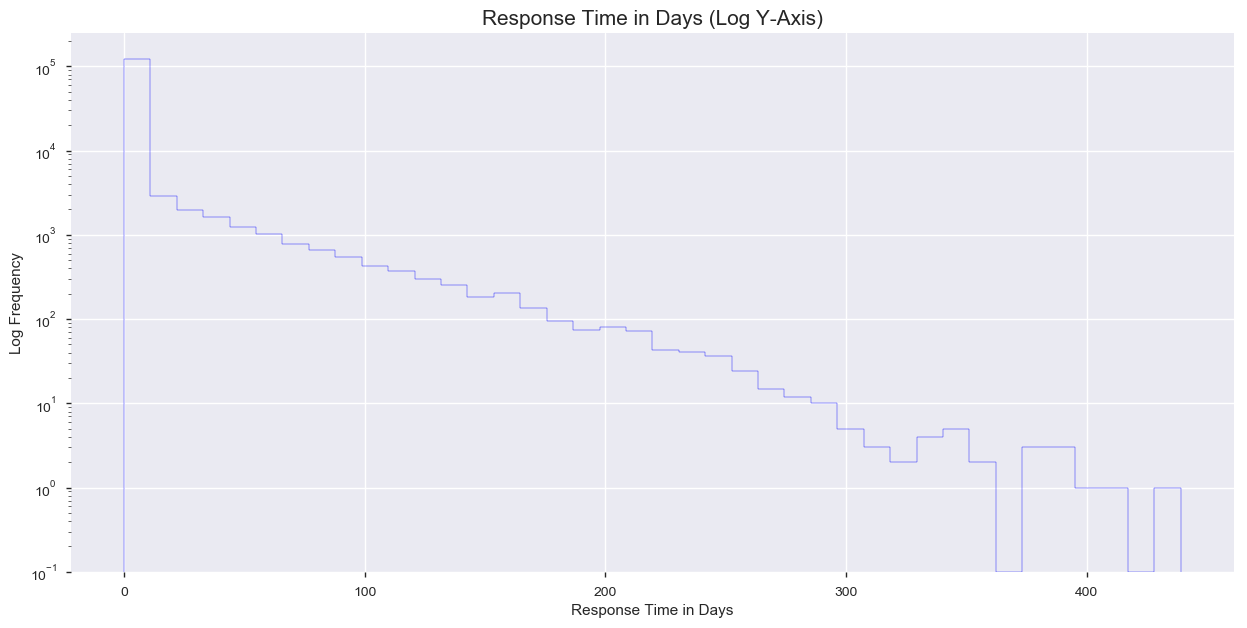

In [149]:
# filter dataframe to requests with a completion date
completed_df = df[df['completion_date'].notnull()]

# calculate response time
completed_df['response_time'] = (completed_df['completion_date'] - completed_df['creation_date']).astype('timedelta64[D]')

# histogram of the response times
plt.figure(figsize=(15, 7))

# max response time is 439 days, let's do 40 bins of ~11 days each
bins = 40
n, bins, patches = plt.hist(completed_df['response_time'], bins=bins, log=True, edgecolor='blue', histtype='step')

plt.title('Response Time in Days (Log Y-Axis)', fontsize=15)
plt.xlabel('Response Time in Days')
plt.ylabel('Log Frequency')
plt.show()

In [150]:
print('Total completed requests:', len(completed_df['response_time']))

Total completed requests: 136952


In [133]:
completed_df['response_time'].value_counts()[:2]

0.0    69321
1.0    34192
2.0     7355
Name: response_time, dtype: int64

In [153]:
completed_df.sort_values(ascending=False, by=['response_time'])[:1]

,any_people_using_property_homeless_childen_gangs_,community_area,completion_date,creation_date,if_the_building_is_open_where_is_the_entry_point_,is_building_open_or_boarded_,is_the_building_currently_vacant_or_occupied_,is_the_building_vacant_due_to_fire_,latitude,location_of_building_on_the_lot_if_garage_change_type_code_to_bgd_,...,status,street_address,type_of_service_request,ward,what_type_of_surface_is_the_graffiti_on_,where_is_the_graffiti_located_,x_coordinate,y_coordinate,zip_code,response_time
129514,NaN,73.0,2018-04-02,2017-01-18,NaN,NaN,NaN,NaN,41.716956,NaN,...,Completed,9736 S BEVERLY AVE,Alley Light Out,21.0,NaN,NaN,1.167777e+06,1.840167e+06,60643.0,439.0


#### Insight #3:
Most requests are quickly completed, most often within a day or two. However, the longest service request (alley light out) took 439 days.

#### a. Graffiti Removal

In [154]:
graffiti_removal = df[df['type_of_service_request'] == 'Graffiti Removal']

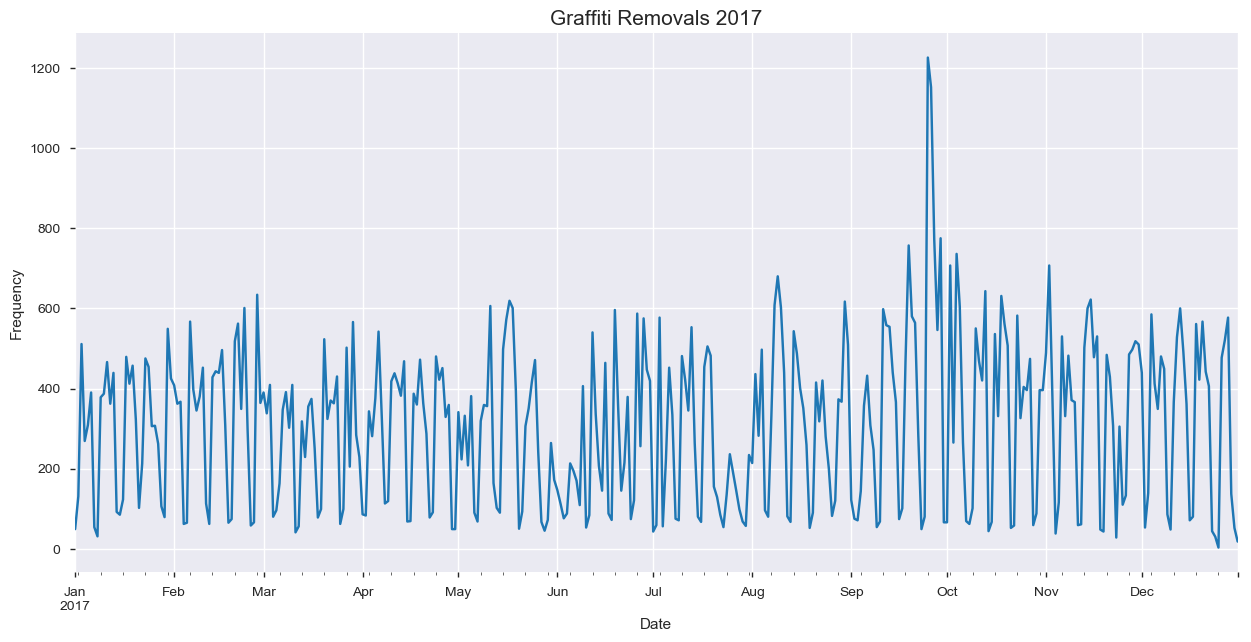

In [155]:
graffiti_removal.groupby('creation_date').size().plot(figsize=(15,7))

plt.title('Graffiti Removals 2017', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

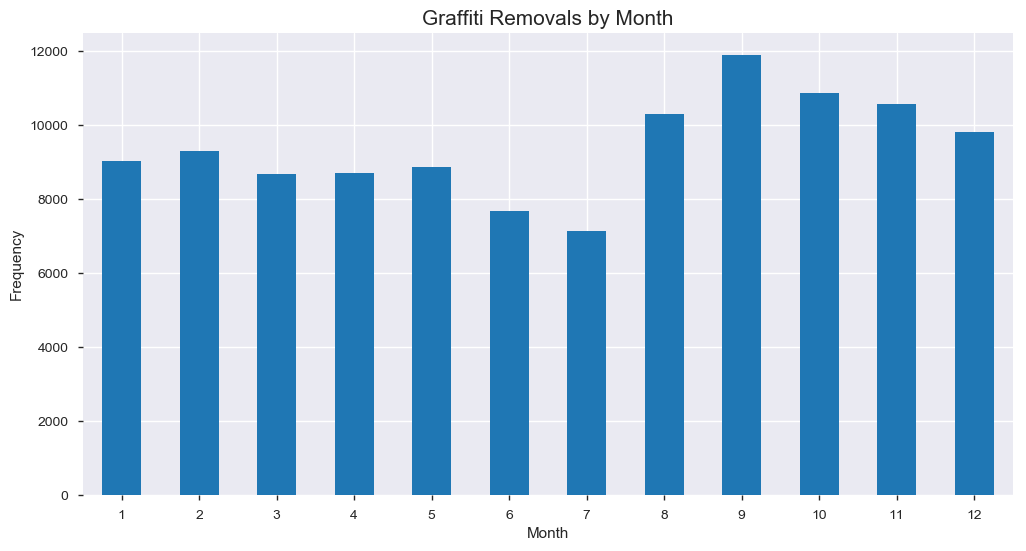

In [156]:
fig, ax = plt.subplots()

df[df['type_of_service_request'] == 'Graffiti Removal'].groupby(
    pd.Grouper(key='creation_date', freq='M')).size().plot(kind='bar', figsize=(12,6), rot=0)

ax.set_xticklabels(range(1, 13))

plt.title('Graffiti Removals by Month', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Frequency')

plt.show()

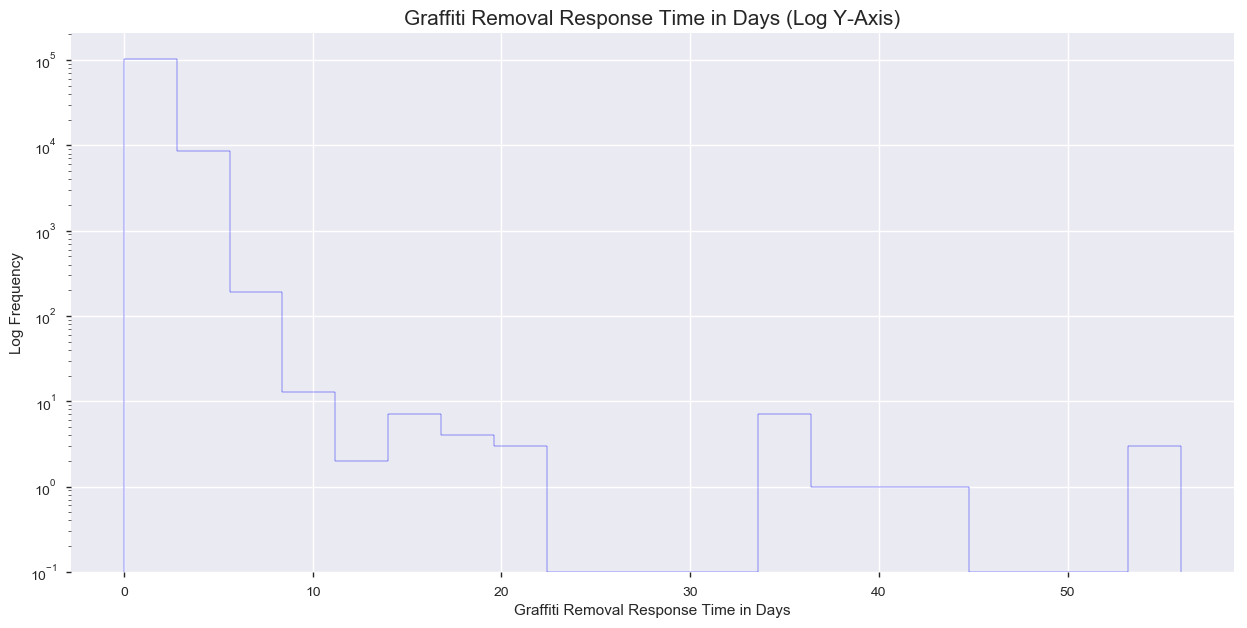

In [157]:
# get graffiti removal response time data
graffiti_removal_response_time = completed_df[completed_df['type_of_service_request'] == 'Graffiti Removal']['response_time']

# histogram of the response times
plt.figure(figsize=(15, 7))

# max response time is ~60 days, let's do 20 bins of ~3 days each
bins = 20
n, bins, patches = plt.hist(graffiti_removal_response_time, bins=bins, log=True, edgecolor='blue', histtype='step')

plt.title('Graffiti Removal Response Time in Days (Log Y-Axis)', fontsize=15)
plt.xlabel('Graffiti Removal Response Time in Days')
plt.ylabel('Log Frequency')
plt.show()

#### b. Vacant/Abandoned Buildings

In [158]:
vacant_buildings = df[df['type_of_service_request'] == 'Vacant/Abandoned Building']

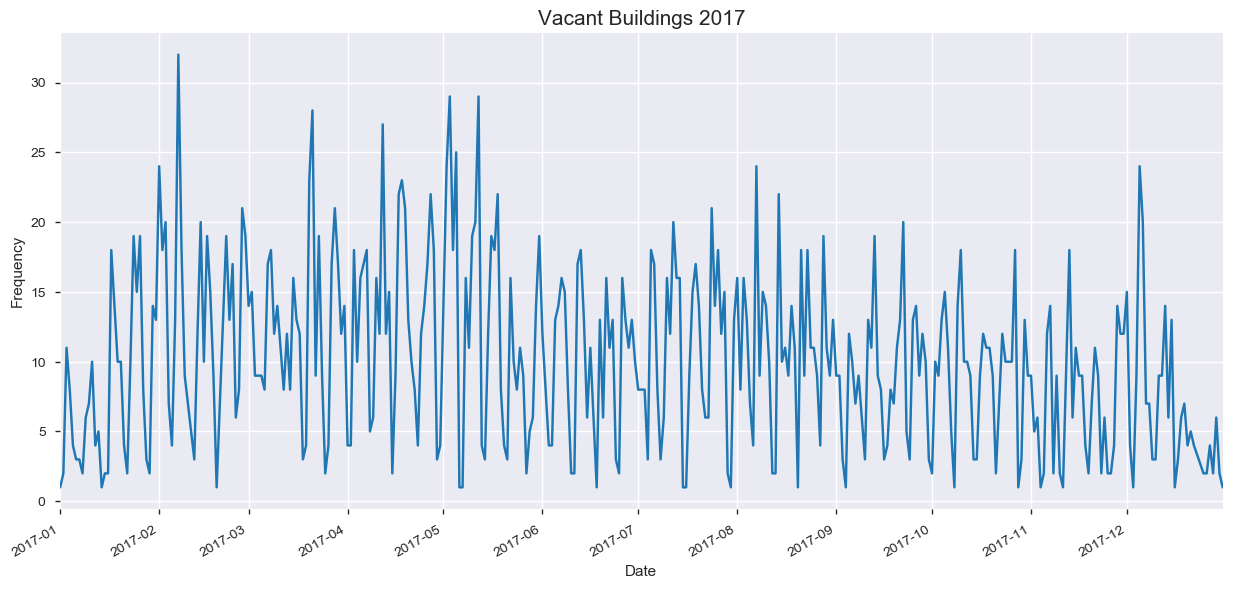

In [159]:
vacant_buildings.groupby('creation_date').size().plot(figsize=(15,7))

plt.title('Vacant Buildings 2017', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

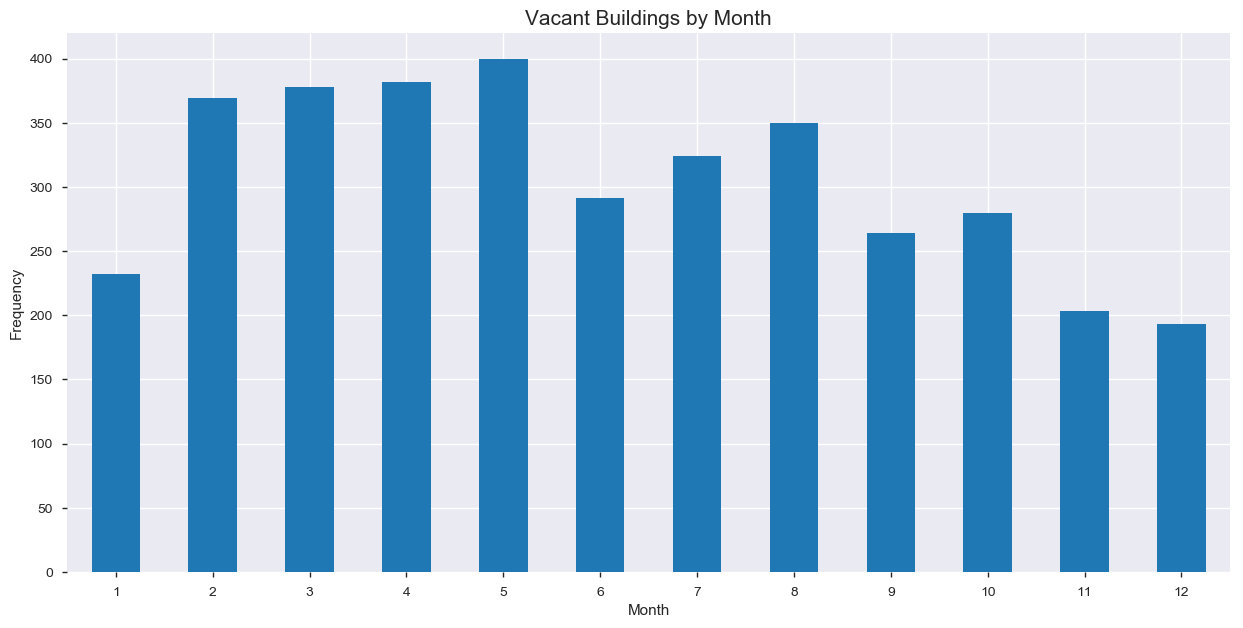

In [166]:
fig, ax = plt.subplots()

df[df['type_of_service_request'] == 'Vacant/Abandoned Building'].groupby(
    pd.Grouper(key='creation_date', freq='M')).size().plot(kind='bar', figsize=(15,7), rot=0)

ax.set_xticklabels(range(1, 13))

plt.title('Vacant Buildings by Month', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Frequency')

plt.show()

#### Insight 4:
Vacant buildings requests are fewer in November - January. It could be that fewer people are outside walking past vacant buildings.

#### c. Alley Lights Out

In [167]:
alley_lights_out = df[df['type_of_service_request'] == 'Alley Light Out']

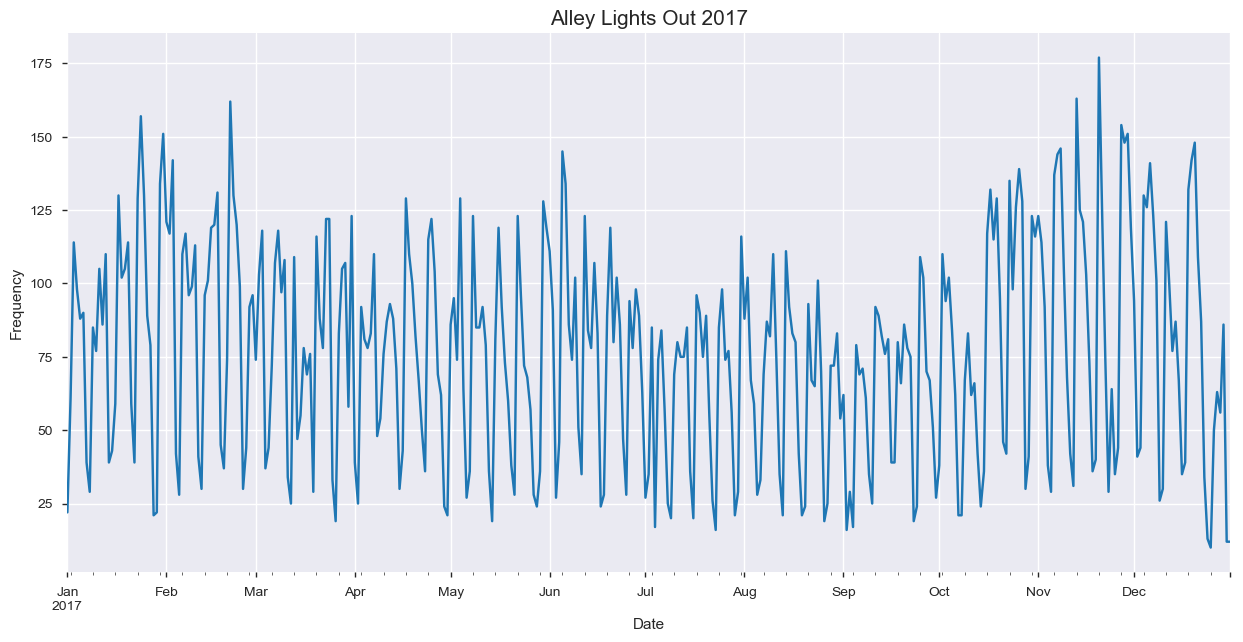

In [168]:
alley_lights_out.groupby('creation_date').size().plot(figsize=(15,7))

plt.title('Alley Lights Out 2017', fontsize=15)
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.show()

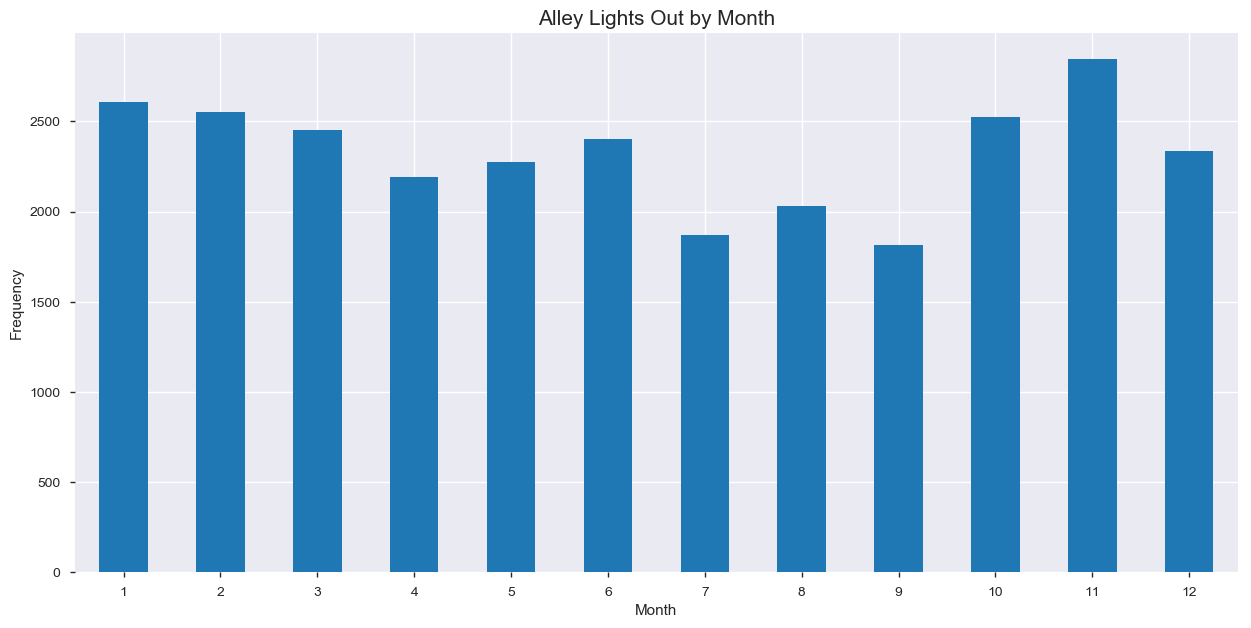

In [169]:
fig, ax = plt.subplots()

df[df['type_of_service_request'] == 'Alley Light Out'].groupby(
    pd.Grouper(key='creation_date', freq='M')).size().plot(kind='bar', figsize=(15,7), rot=0)

ax.set_xticklabels(range(1, 13))

plt.title('Alley Lights Out by Month', fontsize=15)
plt.xlabel('Month')
plt.ylabel('Frequency')

plt.show()

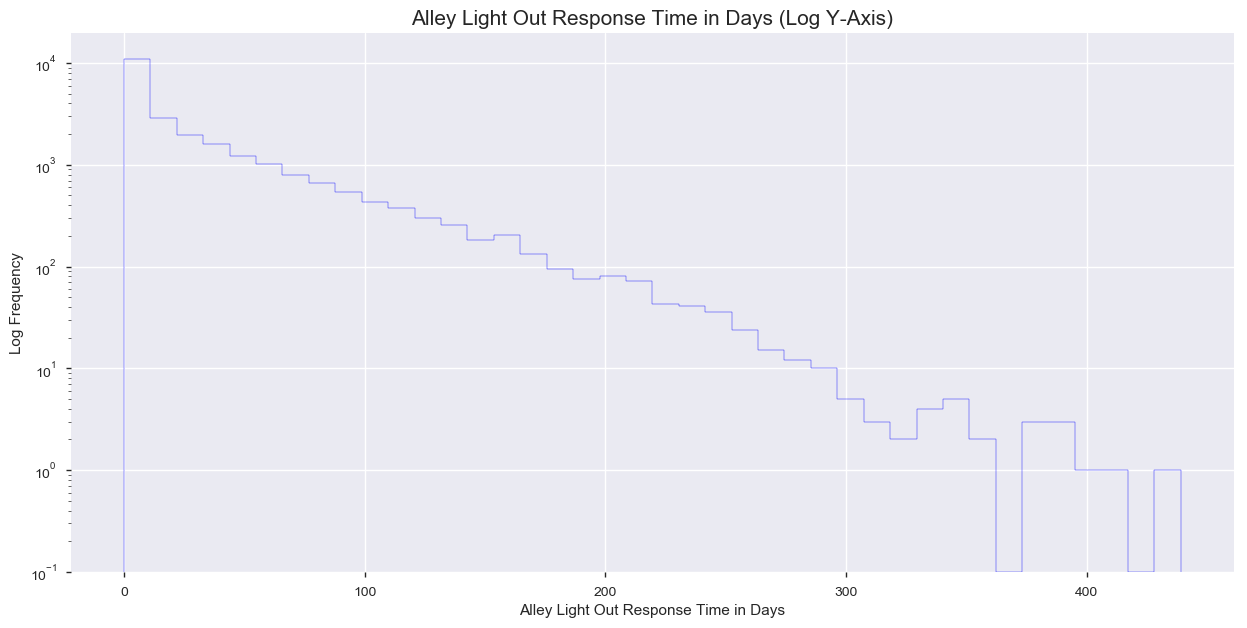

In [170]:
# get alley light out response time data
alley_light_response_time = completed_df[completed_df['type_of_service_request'] == 'Alley Light Out']['response_time']

# histogram of the response times
plt.figure(figsize=(15, 7))

# max response time is ~400 days, let's do 40 bins of ~10 days each
bins = 40
n, bins, patches = plt.hist(alley_light_response_time, bins=bins, log=True, edgecolor='blue', histtype='step')

plt.title('Alley Light Out Response Time in Days (Log Y-Axis)', fontsize=15)
plt.xlabel('Alley Light Out Response Time in Days')
plt.ylabel('Log Frequency')
plt.show()

#### Insight #5:
Graffiti removal requests' responses are much quicker than alley light out requests'. Perhaps alley light outs need more information about the type of light or difficulty in repairing the light in order to be fixed more promptly.

<h3><center>Problem 2: Data Augmentation and APIs</center></h3>
All of the service requests you just analyzed have address and lat/long fields. The task is to augment that data with American Community Survey data. For each address, use one of the census APIs to get some additional data (at least 3-4 useful variables) about the block where the 311 request came from. This could include information about demographics of the block (race, income, family size, etc.). If you run into API rate limit issues, just do it on “Vacant and Abandoned Buildings Reported” and “Alley Lights Out” and for the past 3 months.

Based on this augmented data, provide some descriptive statistics to describe:
1. What types of blocks get “Vacant and Abandoned Buildings Reported”?
2. What types of blocks get “Alley Lights Out”?
3. Does that change over time in the data you collected?
4. What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Alley Lights Out”?

### ACS 5-Year Detailed Tables

I've decided to use cenpy to explore and download data from Census APIs.

In [172]:
import cenpy as c

# ACS dataset
dataset = 'ACSDT5Y2016'
c.explorer.explain(dataset)

{'ACS 5-Year Detailed Tables': 'The American Community Survey (ACS) is an ongoing survey that provides data every year -- giving communities the current information they need to plan investments and services. The ACS covers a broad range of topics about social, economic, demographic, and housing characteristics of the U.S. population.  Summary files include the following geographies: nation, all states (including DC and Puerto Rico), all metropolitan areas, all congressional districts (114th congress), all counties, all places, and all tracts and block groups.  Summary files contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population and housing counts. There are over 64,000 variables in this dataset.'}

In [173]:
# connect to dataset
conn = c.base.Connection(dataset)

I'm interested in augmenting the service requests dataset with tract-level data for:
1. Median Household Income
2. Educational Attainment
3. Ratio of Income to Poverty Level
4. Ratio of Citizens to Non-Citizens

In the ACS 5-year detailed tables, the variables of interest are detailed in the table below.

In [174]:
descriptions_of_variables = []

# ACS variables of interest
variables = ['B19019_001E', 'B23006_001E', 'B23006_023E', 
             'B05010_001E', 'B05010_002E', 'B05010_010E', 'B05010_018E',
             'B05001_001E', 'B05001_006E']

for v in variables:
    descriptions_of_variables.append((v, conn.variables.loc[v]['concept'], conn.variables.loc[v]['label']))
    
# descriptions of ACS variables of interest
pd.DataFrame(descriptions_of_variables, columns=['variable', 'concept', 'label'])

,variable,concept,label
0,B19019_001E,MEDIAN HOUSEHOLD INCOME IN THE PAST 12 MONTHS ...,Estimate!!Total
1,B23006_001E,EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FO...,Estimate!!Total
2,B23006_023E,EDUCATIONAL ATTAINMENT BY EMPLOYMENT STATUS FO...,Estimate!!Total!!Bachelor's degree or higher
3,B05010_001E,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,Estimate!!Total
4,B05010_002E,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,Estimate!!Total!!Under 1.00
5,B05010_010E,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,Estimate!!Total!!1.00 to 1.99
6,B05010_018E,RATIO OF INCOME TO POVERTY LEVEL IN THE PAST 1...,Estimate!!Total!!2.0 and over
7,B05001_001E,NATIVITY AND CITIZENSHIP STATUS IN THE UNITED ...,Estimate!!Total
8,B05001_006E,NATIVITY AND CITIZENSHIP STATUS IN THE UNITED ...,Estimate!!Total!!Not a U.S. citizen


In [175]:
### QUERY CONSTRUCTION

# query by tract
geo_unit = 'tract:*'

# filter for Cook County, Illinois
geo_filter = {'state': '17', 'county': '031'}

# query
acs = conn.query(variables, geo_unit=geo_unit, geo_filter=geo_filter)

C:\Users\roseg\Documents\Anaconda\lib\site-packages\cenpy\remote.py:172: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  df[cols] = df[cols].convert_objects(convert_numeric=convert_numeric)


In [176]:
### PREPROCESSING

# filter columns
acs = acs[['B19019_001E', 'B23006_001E', 'B23006_023E', 
             'B05010_001E', 'B05010_002E', 'B05010_010E', 'B05010_018E',
             'B05001_001E', 'B05001_006E', 'tract']]

# rename columns
acs.columns = ['median_income', 'total_educ', 'bachelors_or_higher', 'poverty_ratio_total',
               'poverty_ratio_under_1', 'poverty_ratio_1_to_2', 'poverty_ratio_above_2',
               'citizens_and_non_citizens', 'non_citizens', 'tract']

# convert tract column type to int
acs['tract'] = acs['tract'].astype(int)

In [177]:
acs.head()

,median_income,total_educ,bachelors_or_higher,poverty_ratio_total,poverty_ratio_under_1,poverty_ratio_1_to_2,poverty_ratio_above_2,citizens_and_non_citizens,non_citizens,tract
0,29861,2976,1061,791,485,77,229,4388,411,10100
1,38861,4376,1449,1473,717,266,490,7032,1409,10201
2,29432,1317,547,322,134,119,69,2275,457,10202
3,37515,3920,1519,835,176,396,263,6205,969,10300
4,37228,2338,1604,703,0,293,410,5603,297,10400


#### Create New Features

Total numbers of educational attainment and educational attainment of bachelors or higher aren't intuitively understood. I want to derive a new column that is a percentage of less than a bachelors divided by the total numbers for educational attainment in a tract.

Similary, I want to convert numbers of non-citizens and poverty ratios into percentages.

In [178]:
# create more useful features
acs['educ_less_than_bachelors'] = (acs['total_educ'] - acs['bachelors_or_higher'])/acs['total_educ']
acs['citizens'] = (acs['citizens_and_non_citizens'] - acs['non_citizens'])/acs['citizens_and_non_citizens']
acs['pov_ratio_under_1'] = acs['poverty_ratio_under_1']/acs['poverty_ratio_total']
acs['pov_ratio_1_to_2'] = acs['poverty_ratio_1_to_2']/acs['poverty_ratio_total']
acs['pov_ratio_above_2'] = acs['poverty_ratio_above_2']/acs['poverty_ratio_total']

In [179]:
# drop unnecessary columns
acs = acs.drop(['total_educ', 'bachelors_or_higher', 'poverty_ratio_total',
                'poverty_ratio_under_1', 'poverty_ratio_1_to_2', 'poverty_ratio_above_2',
                'citizens_and_non_citizens', 'non_citizens'], axis=1)

In [181]:
acs.describe()

,median_income,tract,educ_less_than_bachelors,citizens,pov_ratio_under_1,pov_ratio_1_to_2,pov_ratio_above_2
count,1.319000e+03,1319.000000,1315.000000,1315.000000,1315.000000,1315.000000,1315.000000
mean,-3.479241e+06,565847.085671,0.628183,0.899114,0.236754,0.209321,0.553925
std,4.845997e+07,294669.246393,0.251074,0.095323,0.207356,0.149210,0.281862
min,-6.666667e+08,10100.000000,0.040359,0.567669,0.000000,0.000000,0.000000
25%,3.658900e+04,252101.500000,0.452300,0.850444,0.057639,0.084707,0.306769
50%,5.269200e+04,720400.000000,0.692155,0.929958,0.188720,0.192059,0.549001
75%,7.490400e+04,817250.000000,0.847158,0.975165,0.383328,0.323863,0.810867
max,2.400000e+05,990000.000000,1.000000,1.000000,0.980716,0.800000,1.000000


#### Check Variable Ranges
Upon checking min and max values for each variable, I noticed that some tracts have -666666666 as the median income and need to be removed.

In [41]:
acs.sort_values('median_income').head(8)

,median_income,tract,educ_less_than_bachelors,citizens,pov_ratio_under_1,pov_ratio_1_to_2,pov_ratio_above_2
1318,-666666666,990000,NaN,NaN,NaN,NaN,NaN
1316,-666666666,980000,NaN,NaN,NaN,NaN,NaN
129,-666666666,80400,0.452323,0.919489,0.624782,0.068063,0.307155
1247,-666666666,835700,0.896321,1.000000,0.300926,0.416667,0.282407
1317,-666666666,980100,NaN,NaN,NaN,NaN,NaN
408,-666666666,381500,0.788571,1.000000,0.575758,0.424242,0.000000
409,-666666666,381700,NaN,NaN,NaN,NaN,NaN
1302,9485,842500,0.910569,0.995753,0.889528,0.024166,0.086306


In [42]:
# drop median income values below 0
acs = acs[acs['median_income'] > 0]

#### Match Tracts to Community Areas
Lastly, since the ACS dataset is based on tracts, I need to match tracts to community area equivalents before I can merge it with Chicago service request data.

I used the 'Boundaries - Census Tracts - 2010' dataset on the Chicago Data Portal: <br>
https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik/data

In [43]:
### MATCH TRACT TO COMMUNITY AREA

# load equivalency file found on https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-Census-Tracts-2010/5jrd-6zik/data
equivalencies = pd.read_csv('data/CensusTractsTIGER2010.csv')

# filter columns
equivalencies = equivalencies[['TRACTCE10', 'COMMAREA']]

# rename columns
equivalencies.columns = ['tract', 'community_area']

In [44]:
# merge equivalencies with acs
acs_merged = pd.merge(acs, equivalencies, on=['tract'])

In [45]:
# merge acs_merged with df
df_all = pd.merge(df, acs_merged, on=['community_area'])

#### Analysis

Now that we've merged ACS data with service request data, we can answer the following questions:
1. What types of blocks get “Vacant and Abandoned Buildings Reported”?
2. What types of blocks get “Alley Lights Out”?
3. Does that change over time in the data you collected?
4. What is the difference in blocks that get “Vacant and Abandoned Buildings Reported” vs “Alley Lights Out”?

First, let's look at the correlations between the new socioeconomic variables and community area.

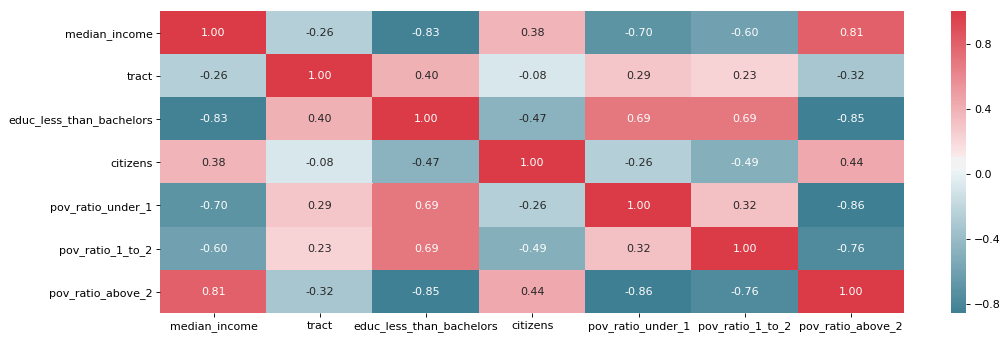

In [53]:
corr2 = df_all[acs_merged.columns].corr()
fig = plt.figure(figsize=(15, 5), dpi=80) 
sns.heatmap(corr2, annot=True,  fmt='.2f', cmap=sns.diverging_palette(220, 10, as_cmap=True))
plt.show()

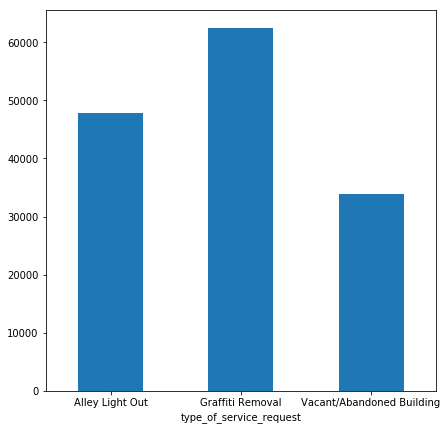

In [381]:
df_all.groupby(['type_of_service_request']).mean()['median_income'].plot(kind='bar', figsize=(7, 7), rot=0)

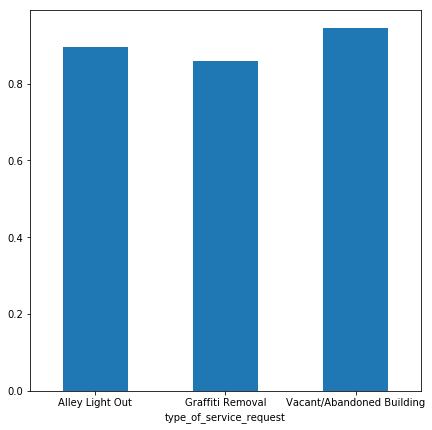

In [387]:
df_all.groupby(['type_of_service_request']).mean()['citizens'].plot(kind='bar', figsize=(7, 7), rot=0)

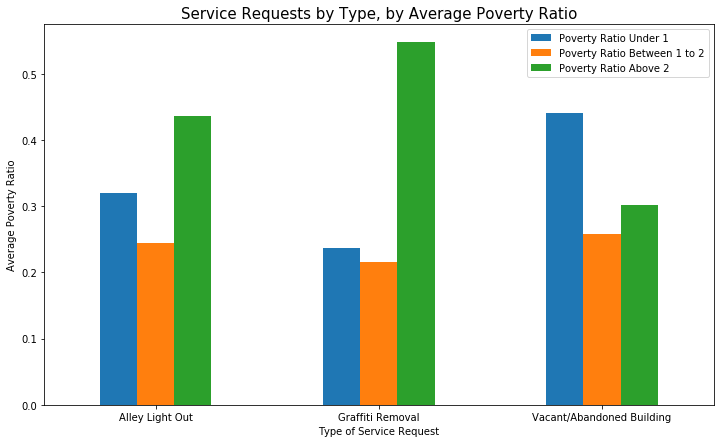

In [416]:
df_all.groupby(['type_of_service_request']).mean()[['pov_ratio_under_1', 'pov_ratio_1_to_2',
                                                    'pov_ratio_above_2']].plot(kind='bar', figsize=(12, 7), rot=0)

plt.title('Service Requests by Type, by Average Poverty Ratio', fontsize=15)
plt.xlabel('Type of Service Request')
plt.ylabel('Average Poverty Ratio')
plt.legend(('Poverty Ratio Under 1', 'Poverty Ratio Between 1 to 2', 'Poverty Ratio Above 2'))
plt.show()

In [403]:
# filter dataframe to requests with a completion date
completed_df_all = df_all[df_all['completion_date'].notnull()]

# calculate response time
completed_df_all['response_time'] = (completed_df_all['completion_date'] - completed_df_all['creation_date']).astype('timedelta64[D]')

C:\Users\roseg\Documents\Anaconda\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


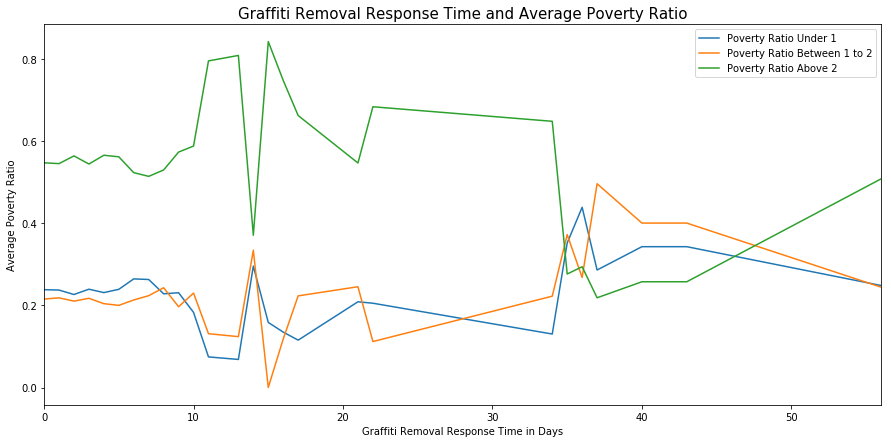

In [426]:
completed_df_all[completed_df_all['type_of_service_request'] == 'Graffiti Removal'].groupby(
    ['response_time']).mean()[['pov_ratio_under_1', 'pov_ratio_1_to_2', 'pov_ratio_above_2']].plot(figsize=(15,7))

plt.title('Graffiti Removal Response Time and Average Poverty Ratio', fontsize=15)
plt.xlabel('Graffiti Removal Response Time in Days')
plt.ylabel('Average Poverty Ratio')
plt.legend(('Poverty Ratio Under 1', 'Poverty Ratio Between 1 to 2', 'Poverty Ratio Above 2'))
plt.show()

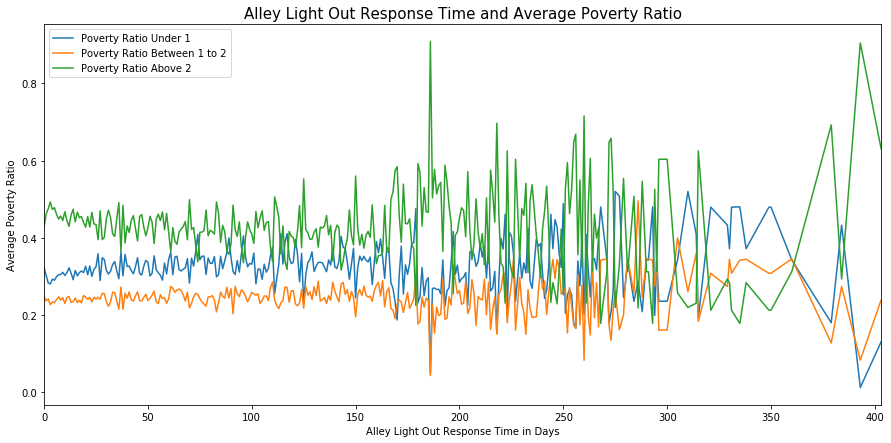

In [427]:
completed_df_all[completed_df_all['type_of_service_request'] == 'Alley Light Out'].groupby(
    ['response_time']).mean()[['pov_ratio_under_1', 'pov_ratio_1_to_2', 'pov_ratio_above_2']].plot(figsize=(15,7))

plt.title('Alley Light Out Response Time and Average Poverty Ratio', fontsize=15)
plt.xlabel('Alley Light Out Response Time in Days')
plt.ylabel('Average Poverty Ratio')
plt.legend(('Poverty Ratio Under 1', 'Poverty Ratio Between 1 to 2', 'Poverty Ratio Above 2'))
plt.show()

<h3><center>Problem 3:</center></h3>
Assume you are running the 311 call center for Chicago. You get a call from 3600 W Roosevelt Ave.
1. Of the three types of requests you have data for, which request type is the most likely given the call came from 3600 W Roosevelt Ave? What are the probabilities for each type of request?
2. Let’s now assume that a call comes in about Graffiti Removal. Which is more likely – that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?
3. Now assume that you don’t have access to all the raw data and you know the following things:

    There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of the 600 calls from Garfield Park, 100 of them are about Graffiti Removal. Of the 400 calls from Uptown, 160 are about Graffiti Removal. If a call comes about Graffiti Removal, how much more/less likely is it that the call came from Garfield Park versus Uptown?

A quick search shows that this address is not in our dataset:

In [464]:
address = '3600 W Roosevelt Ave'.upper()
len(df_all[df_all['street_address'] == address])

0

It's possible that I know that 3600 W Roosevelt Ave doesn't exist in Chicago, and most likely, I want 3600 W Roosevelt Road, which does exist in Chicago and in our dataset:

In [463]:
len(df_all[df_all['street_address'] == '3600 W ROOSEVELT RD'])

15

However, to be more safe, I can use fuzzy matching to find the closest address in the dataset.

In [465]:
import difflib

In [494]:
unique_addresses = list(set((df_all[df_all['street_address'].notnull()]['street_address']).tolist()))

In [499]:
closest_address_match = difflib.get_close_matches(address, unique_addresses, 1)[0]

In [500]:
len(df_all[df_all['street_address'] == closest_address_match])

15

#### Of the three types of requests you have data for, which request type is the most likely given the call came from 3600 W Roosevelt Ave? What are the probabilities for each type of request?

In [503]:
df2 = df_all[df_all['street_address'] == closest_address_match]

In [519]:
df2['type_of_service_request'].value_counts().sort_values(ascending=False)

Graffiti Removal    15
Name: type_of_service_request, dtype: int64

Since all service requests from this address are for graffiti removal, that is the most likely request type.

#### Let’s now assume that a call comes in about Graffiti Removal. Which is more likely – that the call came from Garfield Park or Uptown? How much more or less likely is it to be from Garfield Park vs Uptown?

A Google search yields that the zip code for Garfield Park is 60612 and for Uptown is 60640.

In [526]:
gp_graffiti_removal = df_all[(df_all['type_of_service_request'] == 'Graffiti Removal') & (df_all['zip_code'] == 60612)]
u_graffiti_removal = df_all[(df_all['type_of_service_request'] == 'Graffiti Removal') & (df_all['zip_code'] == 60640)]

In [530]:
percent_gp =len(gp_graffiti_removal)/(len(gp_graffiti_removal) + len(u_graffiti_removal))
percent_u =len(u_graffiti_removal)/(len(gp_graffiti_removal) + len(u_graffiti_removal))

In [538]:
print('Probability that a call about Graffiti Removal came from Garfield Park', round(percent_gp, 2))
print('Probability that a call about Graffiti Removal came from Uptown', round(percent_u, 2))

Probability that a call about Graffiti Removal came from Garfield Park 0.57
Probability that a call about Graffiti Removal came from Uptown 0.43


It's 14% more likely that a call about Graffiti Removal came from Garfield Park than Uptown.

#### Now assume that you don’t have access to all the raw data and you know the following things:
There are a total of 1000 calls, 600 from Garfield Park and 400 from Uptown. Of the 600 calls from Garfield Park, 100 of them are about Graffiti Removal. Of the 400 calls from Uptown, 160 are about Graffiti Removal. If a call comes about Graffiti Removal, how much more/less likely is it that the call came from Garfield Park versus Uptown?

In [545]:
print('Probability that a call about Graffiti Removal came from Garfield Park', round(100/600, 2))
print('Probability that a call about Graffiti Removal came from Uptown', round(160/400, 2))

Probability that a call about Graffiti Removal came from Garfield Park 0.17
Probability that a call about Graffiti Removal came from Uptown 0.4


It's 23% more likely that a call about Graffiti Removal came from Uptown than Garfield Park.